# Basic LSTM Example
Code taken from: https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

In [7]:
df = pd.read_csv('airline-passengers.csv')
timeseries = df[["Passengers"]].values.astype('float32')

timeseries_normalized = (timeseries - np.min(timeseries)) / (np.max(timeseries) - np.min(timeseries))

# train-test split for time series
train_size = int(len(timeseries_normalized) * 0.67)
train, test = timeseries_normalized[:train_size], timeseries_normalized[train_size:]
print(train.shape, test.shape)

def create_dataset(dataset, lookback):
    """
    Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(np.array(X)), torch.tensor(np.array(y))
 
lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

(96, 1) (48, 1)


In [6]:
print(f"Train set: Samples shape {X_train.shape}, min {torch.min(X_train).item()}, max {torch.max(X_train).item()}; labels shape {y_train.shape}, min {torch.min(y_train).item()}, max {torch.max(y_train).item()}")
print(f"Test set: Samples shape {X_test.shape}, min {torch.min(X_test).item()}, max {torch.max(X_test).item()}; labels shape {y_test.shape}, min {torch.min(y_test).item()}, max {torch.max(y_test).item()}")

Train set: Samples shape torch.Size([92, 4, 1]), min 0.0, max 0.5965250730514526; labels shape torch.Size([92, 4, 1]), min 0.0, max 0.5965250730514526
Test set: Samples shape torch.Size([44, 4, 1]), min 0.3803088665008545, max 1.0; labels shape torch.Size([44, 4, 1]), min 0.3803088665008545, max 1.0


In [8]:
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device.")
model = AirModel()
model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
trainloader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
# The `TensorDataset` can take `transform` as input!
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

Using cuda:0 device.


In [10]:
n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for batch_idx, (X_batch, y_batch) in enumerate(trainloader):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = torch.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = torch.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 0.2695, test RMSE 0.6283
Epoch 100: train RMSE 0.0428, test RMSE 0.0918
Epoch 200: train RMSE 0.0424, test RMSE 0.0903
Epoch 300: train RMSE 0.0413, test RMSE 0.1011
Epoch 400: train RMSE 0.0408, test RMSE 0.0996
Epoch 500: train RMSE 0.0411, test RMSE 0.1046
Epoch 600: train RMSE 0.0403, test RMSE 0.1066
Epoch 700: train RMSE 0.0402, test RMSE 0.1067
Epoch 800: train RMSE 0.0403, test RMSE 0.1093
Epoch 900: train RMSE 0.0397, test RMSE 0.1090
Epoch 1000: train RMSE 0.0403, test RMSE 0.1148
Epoch 1100: train RMSE 0.0395, test RMSE 0.1046
Epoch 1200: train RMSE 0.0395, test RMSE 0.1064
Epoch 1300: train RMSE 0.0394, test RMSE 0.1115
Epoch 1400: train RMSE 0.0391, test RMSE 0.1089
Epoch 1500: train RMSE 0.0389, test RMSE 0.1114
Epoch 1600: train RMSE 0.0387, test RMSE 0.1180
Epoch 1700: train RMSE 0.0384, test RMSE 0.1195
Epoch 1800: train RMSE 0.0383, test RMSE 0.1102
Epoch 1900: train RMSE 0.0385, test RMSE 0.1152


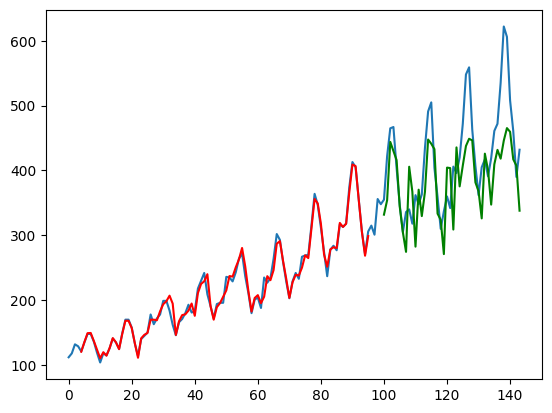

In [15]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train).cpu()[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test).cpu()[:, -1, :]
# plot
plt.plot(timeseries)
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()